# 1. Import libraries and load preprocessed data


In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline



In [91]:
# Load data
train_data = pd.read_csv('train_official.csv', index_col='Id')
test_data = pd.read_csv('test_official.csv', index_col='Id')
train_data.head(1)

,LotFrontage,LotArea,Street,Alley,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,-0.244415,-0.257308,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.621525,...,0,0,0,1,0,0,0,1,0,12.247699


In [92]:
# Seperate features and target variable
X_train = train_data.drop(['SalePrice'], axis=1)
y = train_data.SalePrice


In [94]:
X_train.shape

(1458, 228)

# 2. Modeling

Trong model evaluation, thường thì ta sẽ chia toàn bộ data làm 2 tập train và test. Tuy nhiên data khá nhỏ, nên nếu chia như vậy, thì có lẽ mô hình sẽ dễ bị overfitting, do đó, ta dùng `cross-validation` để train mô hình.


Đề bài yêu cầu đánh giá mô hình bằng độ đo RMSE, tuy nhiên do target variable đã được biến đổi qua log(1 + y), nên MSE cho log(1 + y) là MSLE - Mean Squared Logarithmic Error.

In [95]:
from sklearn.model_selection import KFold, cross_val_score

n_folds = 5


def getRMSLE(model):
    """
    Return the average RMSLE over all folds of training data.
    """
    # Set KFold to shuffle data before the split
    kf = KFold(n_folds, shuffle=True, random_state=42)

    # Get RMSLE score
    rmse = np.sqrt(-cross_val_score(
        model, X_train, y, scoring="neg_mean_squared_error", cv=kf))

    return rmse.mean()

## 2.1 Regularized Regressions

### 2.1.1 Ridge

Với thuật toán regularized linear regression (Ridge), ta đi tối thiểu:

$$ J(\theta) = \frac{1}{2m} \left( \sum_{i=1}^m \left( h_\theta\left( x^{(i)} \right) - y^{(i)} \right)^2 \right) + \frac{\lambda}{2m} \left( \sum_{j=1}^n \theta_j^2 \right)$$

với $\lambda$ là một regularization parameter quyết định degree của regularization (do đó, ngăn overfitting). Regularization term này sẽ penalty (phạt) trên the overall cost J. Khi cường độ tham số mô hình $\theta_j$ tăng, lượng penalty sẽ càng cao.

Nhóm sẽ tìm $\lambda$ tốt nhất cho smallest **RMSLE** thông qua phương pháp cross-validation:

In [96]:
from sklearn.linear_model import Ridge, Lasso

Best lambda: 13.8
RMSLE: 0.11571736376845394


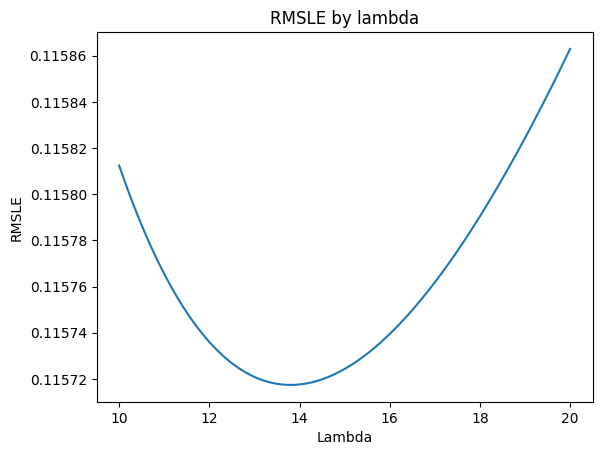

In [97]:
lambda_list = list(np.linspace(10, 20, 101))

rmsle_ridge = [getRMSLE(Ridge(alpha=lambda_)) for lambda_ in lambda_list]
rmsle_ridge = pd.Series(rmsle_ridge, index=lambda_list)

rmsle_ridge.plot(title="RMSLE by lambda")
plt.xlabel("Lambda")
plt.ylabel("RMSLE")

print("Best lambda:", rmsle_ridge.idxmin())
print("RMSLE:", rmsle_ridge.min())

In [43]:
ridge = Ridge(alpha=13.8)

### 2.1.2 Lasso

Lasso Regressionlà một thuật toán tương tự Ridge regression. Sự khác biệt ở đây là regularization term, thay vì dùng **sum of squared of $\theta$**, thì sử dụng **sum of absolute value of $\theta$**:

$$ J(\theta) = \frac{1}{2m} \left( \sum_{i=1}^m \left( h_\theta\left( x^{(i)} \right) - y^{(i)} \right)^2 \right) + \frac{\lambda}{2m} \left( \sum_{j=1}^n |\theta_j| \right)$$

Với phương pháp trên, chọn `lambda_` tốt nhất cho mô hình là  is **0.00058**.

Best lambda: 0.0005808080808080809
RMSLE: 0.11537177658532989


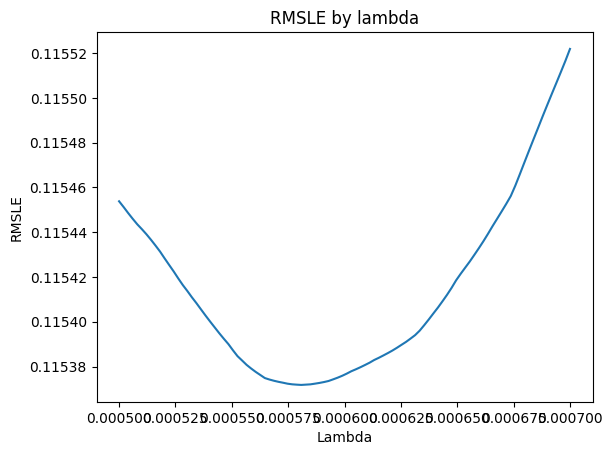

In [98]:
lambda_list = list(np.linspace(0.0005, 0.0007, 100))
rmsle_lasso = [
    getRMSLE(Lasso(alpha=lambda_, max_iter=1000)) for lambda_ in lambda_list
]
rmsle_lasso = pd.Series(rmsle_lasso, index=lambda_list)

rmsle_lasso.plot(title="RMSLE by lambda")
plt.xlabel("Lambda")
plt.ylabel("RMSLE")

print("Best lambda:", rmsle_lasso.idxmin())
print("RMSLE:", rmsle_lasso.min())

In [99]:
lasso = Lasso(alpha=0.00058, max_iter=1000)

## 2.2 XGBRegressor

Theo [hướng dẫn này](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/?fbclid=IwAR1NTAXqgYzjOOFw3qOV5DrcItwNoM73iPvWggnuyVR1PbvORiEUjRunipo) tham số cho thuật toán XGBoost, nhóm đã dùng thuật toán bayesian optimization để tìm các tham số tốt nhất:  `n_estimators`, `max_depth`, `min_child_weight`, `gamma`, `subsample`, `colsample_bytree`, `reg_alpha`, `reg_lambda`, `learning_rate`.

In [100]:
from xgboost import XGBRegressor

### 2.2.1 Hyperparameter tuning use Bayesian Optimization

In [ ]:
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'max_depth': hp.randint('max_depth', 1, 5),
        'gamma': hp.uniform('gamma', 0, 1),
        'learning_rate': hp.choice('learning_rate', [0.001, 0.01, 0.05,0.1]),
        'reg_alpha' : hp.uniform('reg_alpha', 0, 1),
        'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
        'colsample_bytree' :  hp.uniform('colsample_bytree', 0, 1),
        'min_child_weight' : hp.randint('min_child_weight', 0, 10),
        'n_estimators': hp.randint('n_estimators', 1000, 2500)
    }

# Set up the k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

def objective(params):
    
    xgboost = XGBRegressor(seed=0, **params)
    score = cross_val_score(estimator=xgboost, 
                            X=X_train, 
                            y=y, 
                            cv=kfold, 
                            scoring='neg_mean_squared_error', 
                            n_jobs=-1).mean()
    # Loss is negative score
    loss = - score
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

# Optimize
trials = Trials()
best = fmin(fn=objective, 
            space=space, 
            algo=tpe.suggest, 
            max_evals=100, 
            trials=trials)

print('Best hyperparameters:', best)


In [107]:
xgb = XGBRegressor(learning_rate=0.05,
                   n_estimators=2100,
                   max_depth=3,
                   min_child_weight=7,
                   gamma=0.00435,
                   subsample=0.65,
                   colsample_bytree=0.1761,
                   nthread=-1,
                   scale_pos_weight=1,
                   reg_alpha=0.41578,
                   reg_lambda=0.8678,
                   n_jobs=2)
getRMSLE(xgb)

0.11665545482038805

## 2.2 LGBMRegressor

LightGBM là một framork gradient boosting rất mạnh dựa trên thuật toán decision tree. Giống như XGBoost, LightGBM có kết quả tốt trên tập dữ liệu lớn và có tốc độ training nhanh hơn XGBoost nhiều. Theo [hướng dẫn này](https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/?fbclid=IwAR3uYr9U1VDaqh_jEn1cjvMyjEWVHKMaDm_Q9yD1y08OkGBywRR0qpuhhtw), Nhóm đã tunning các tham số: `num_leaves`, `min_data_in_leaf`, `max_depth`, `bagging_fraction`, `feature_fraction`, `max_bin`. Theo như kết quả phía dưới, thì LightGBM cho kết quả tốt hơn XGBoost.

In [48]:
from lightgbm import LGBMRegressor

### 2.2.1 Hyperparameter tuning use bayesian optimization

In [61]:
space={'max_depth': hp.randint('max_depth', 1, 5),
        'learning_rate': hp.choice('learning_rate', [ 0.02, 0.05,0.075, 1]),
        'num_leaves': hp.randint('num_leaves', 10, 50),
        'bagging_fraction':  hp.uniform('bagging_fraction', 0, 1),
        'bagging_freq':  hp.randint('bagging_freq', 0, 10),
        'n_estimators': hp.randint('n_estimators', 100, 1000),
        'max_bin': hp.randint('max_bin', 75, 300),
        'min_sum_hessian_in_leaf ': hp.randint('min_sum_hessian_in_leaf', 1, 50),
        'min_data_in_leaf': hp.randint('min_data_in_leaf', 0, 50),
        'feature_fraction_seed': hp.randint('feature_fraction_seed', 0, 8),
        'bagging_seed': hp.randint('bagging_seed', 0, 10)
    }


# Set up the k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

def objective(params):
    
    lgbm =  LGBMRegressor(objective='regression', seed=1, **params) 
  
    score = cross_val_score(estimator=lgbm, 
                            X=X_train, 
                            y=y, 
                            cv=kfold, 
                            scoring='neg_mean_squared_error', 
                            n_jobs=2).mean()
    
    # Loss is negative score
    loss = - score
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}


# Optimize
trials = Trials()
best = fmin(fn=objective, 
            space=space, 
            algo=tpe.suggest, 
            max_evals=200, 
            trials=trials)

print('Best hyperparameters:', best)

100%|██████████| 200/200 [01:54<00:00,  1.75trial/s, best loss: 0.013999372850348768]
Best hyperparameters: {'bagging_fraction': 0.7926686601831239, 'bagging_freq': 1, 'bagging_seed': 8, 'feature_fraction_seed': 3, 'learning_rate': 1, 'max_bin': 274, 'max_depth': 2, 'min_data_in_leaf': 27, 'min_sum_hessian_in_leaf': 36, 'n_estimators': 926, 'num_leaves': 46}


In [102]:
lgb = LGBMRegressor(objective='regression',
                    learning_rate=0.05,
                    n_estimators=471,
                    num_leaves=10,
                    min_data_in_leaf=4,
                    max_depth=3,
                    max_bin=120,
                    bagging_fraction=0.4586,
                    bagging_freq=1,
                    feature_fraction=0.24,
                    feature_fraction_seed=5,
                    bagging_seed=7,
                    min_sum_hessian_in_leaf=0)
getRMSLE(lgb)

[LightGBM] [Warning] feature_fraction is set=0.24, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0
[LightGBM] [Warning] bagging_fraction is set=0.4586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4586
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.24, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0
[Ligh

0.1144178513898916

## 2.3 Average model

In [103]:
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin, clone


class AveragingModel(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models

    def fit(self, X, y):
        # Create clone models
        self.models_ = [clone(x) for x in self.models]

        # Train cloned models
        for model in self.models_:
            model.fit(X, y)

        return self

    def predict(self, X):
        # Get predictions from trained clone models
        predictions = np.column_stack(
            [model.predict(X) for model in self.models_])

        # Return average predictions
        return np.mean(predictions, axis=1)

In [108]:
avg_model = AveragingModel(models=(ridge, lasso, xgb, lgb))
getRMSLE(avg_model)

[LightGBM] [Warning] feature_fraction is set=0.24, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0
[LightGBM] [Warning] bagging_fraction is set=0.4586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4586
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.24, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0
[Ligh

0.11057992980305145

# 3. Output predicted values to file

In [109]:
my_model = avg_model
my_model.fit(X_train, y)
predictions = my_model.predict(test_data)
final_predictions = np.exp(predictions) - 1
output = pd.DataFrame({'Id': test_data.index, 'SalePrice': final_predictions})
output.to_csv('off_submission.csv', index=False)

[LightGBM] [Warning] feature_fraction is set=0.24, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0
[LightGBM] [Warning] bagging_fraction is set=0.4586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4586
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
